In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import itertools
import warnings
warnings.filterwarnings('ignore')

In [3]:
filename = 'LSTM.csv'

In [4]:
rainfall_data_matrix = pd.read_csv(filename)
rainfall_data_matrix.set_index('YEAR', inplace=True)
rainfall_data_matrix = rainfall_data_matrix.transpose()
rainfall_data_matrix

YEAR,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,...,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030
Jan,6.6,5.2,13.1,23.5,4.2,7.9,1.2,4.4,3.0,9.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Feb,6.5,48.2,22.6,2.8,6.3,11.7,16.0,19.3,21.4,8.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mar,41.6,20.8,18.5,90.6,28.2,15.1,25.7,57.3,6.3,44.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Apr,175.9,112.2,132.4,136.9,125.9,151.6,70.2,135.1,150.7,206.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
May,148.5,214.6,55.4,179.5,544.2,351.3,381.2,353.5,347.2,540.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jun,774.1,576.7,340.5,798.3,782.4,755.4,872.0,713.3,872.8,480.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jul,544.6,430.0,1027.6,640.5,392.8,466.8,835.3,622.7,1155.7,750.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aug,190.6,413.6,356.4,467.0,236.0,319.5,358.8,526.6,397.3,336.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sep,313.8,57.4,100.5,201.6,438.5,178.4,41.3,86.1,405.5,371.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Oct,250.6,339.6,410.5,303.1,378.2,353.3,280.1,191.0,200.4,255.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dates = pd.date_range(start='1951-01', freq='MS', periods=len(rainfall_data_matrix.columns)*12)
dates

DatetimeIndex(['1951-01-01', '1951-02-01', '1951-03-01', '1951-04-01',
               '1951-05-01', '1951-06-01', '1951-07-01', '1951-08-01',
               '1951-09-01', '1951-10-01',
               ...
               '2030-03-01', '2030-04-01', '2030-05-01', '2030-06-01',
               '2030-07-01', '2030-08-01', '2030-09-01', '2030-10-01',
               '2030-11-01', '2030-12-01'],
              dtype='datetime64[ns]', length=960, freq='MS')

Text(0.5, 1.0, 'Month vs Precipitation across all years')

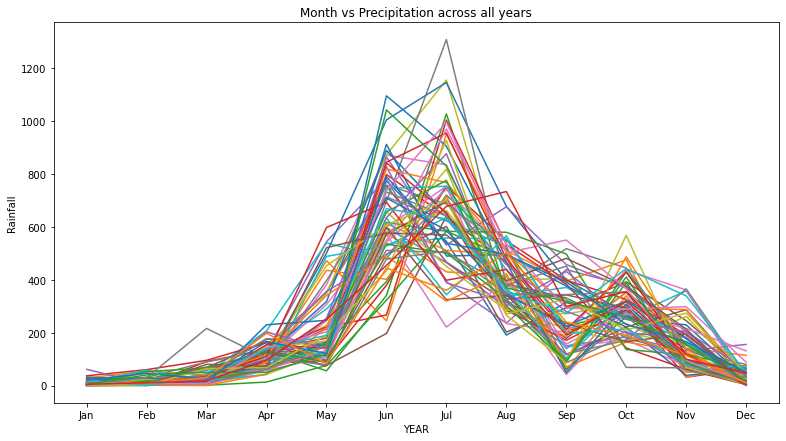

In [6]:
plt.figure(figsize=(13,7))
plt.plot(rainfall_data_matrix)
plt.xlabel('YEAR')
plt.ylabel('Rainfall')
plt.title('Month vs Precipitation across all years')

Text(0.5, 1.0, 'Month vs Precipitation across all years')

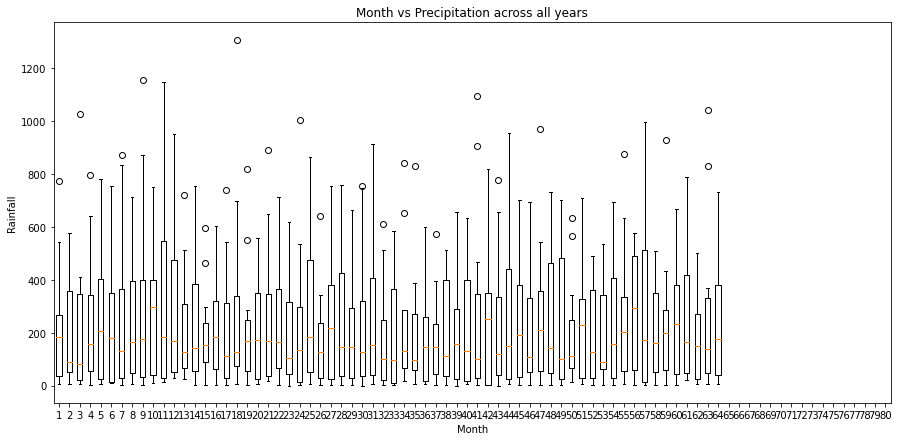

In [7]:
plt.figure(figsize=(15,7))
plt.boxplot(rainfall_data_matrix)
plt.xlabel('Month')
plt.ylabel('Rainfall')
plt.title('Month vs Precipitation across all years')

In [8]:
rainfall_data_matrix_np = rainfall_data_matrix.transpose().to_numpy()

shape = rainfall_data_matrix_np.shape
rainfall_data_matrix_np = rainfall_data_matrix_np.reshape((shape[0] * shape[1], 1))

In [9]:
rainfall_data = pd.DataFrame({'Precipitation': rainfall_data_matrix_np[:,0]})
rainfall_data.set_index(dates, inplace=True)

test_rainfall_data = rainfall_data.loc['2002':'2030']
rainfall_data = rainfall_data.loc[: '2001']
rainfall_data.head()

,Precipitation
1951-01-01,6.6
1951-02-01,6.5
1951-03-01,41.6
1951-04-01,175.9
1951-05-01,148.5


Text(0.5, 1.0, 'Precipitation in mm')

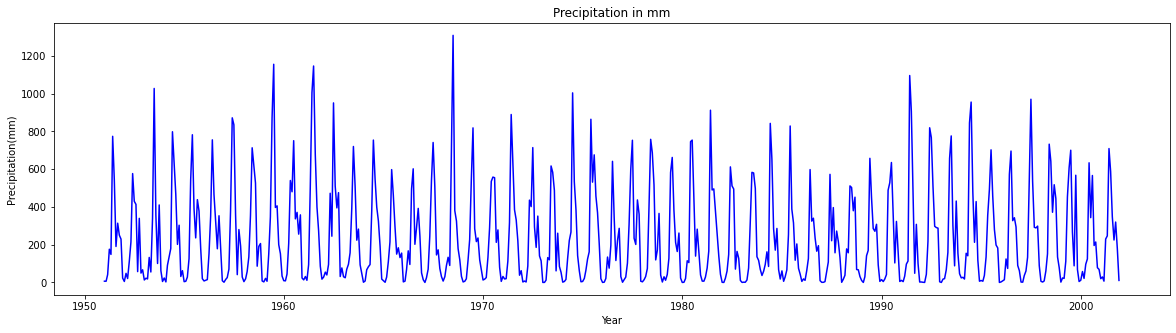

In [10]:
plt.figure(figsize=(20,5))
plt.plot(rainfall_data, color='blue')
plt.xlabel('Year')
plt.ylabel('Precipitation(mm)')
plt.title('Precipitation in mm')

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_data = scaler.fit_transform(rainfall_data)
test_data = scaler.fit_transform(test_rainfall_data)

In [12]:
rainfall_data.head()

,Precipitation
1951-01-01,6.6
1951-02-01,6.5
1951-03-01,41.6
1951-04-01,175.9
1951-05-01,148.5


In [13]:
train_data[:5]

array([[0.0050424 ],
       [0.004966  ],
       [0.03178241],
       [0.13438765],
       [0.11345405]])

In [14]:
scaler.inverse_transform(train_data[:5])

array([[  5.65569562],
       [  5.57606387],
       [ 33.52680877],
       [140.47225151],
       [118.6531515 ]])

In [15]:
print("Shape of train data: " + str(train_data.shape))
print("Shape of test data: " + str(test_data.shape))

Shape of train data: (612, 1)
Shape of test data: (348, 1)


In [16]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []

    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)

In [17]:
look_back = 12
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

In [18]:
testY

array([7.67533340e-04, 5.03693754e-02, 6.31296172e-02, 1.22517509e-01,
       8.50043174e-02, 5.12520388e-01, 4.80859637e-01, 3.13441428e-01,
       8.84582174e-02, 3.72541495e-01, 8.20301257e-02, 7.19562506e-03,
       2.20665835e-03, 5.56461671e-03, 3.28120503e-02, 1.04480476e-01,
       5.73251463e-01, 6.64875756e-01, 3.81655953e-01, 4.21087979e-01,
       1.83824235e-01, 3.04518853e-01, 1.13307109e-01, 9.59416675e-04,
       1.75573251e-02, 5.94838338e-03, 2.43691835e-02, 1.94281877e-01,
       1.31344143e-01, 6.08749880e-01, 8.41120599e-01, 2.88784419e-01,
       4.13412645e-01, 2.39950110e-01, 1.93418402e-01, 5.95797755e-02,
       8.25098340e-03, 1.91883335e-04, 7.64655090e-02, 6.96536506e-02,
       4.99664204e-01, 5.53295596e-01, 5.45908088e-01, 3.79929003e-01,
       4.61287537e-01, 3.59205603e-01, 2.03971985e-01, 1.43912501e-03,
       0.00000000e+00, 4.98896671e-03, 7.29156673e-03, 1.37196584e-01,
       1.94089993e-01, 7.07090089e-01, 9.55291183e-01, 4.81723112e-01,
      

In [19]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (599, 12)
Shape of train labels: (599,)
Shape of test input: (335, 12)
Shape of test labels: (335,)


In [20]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [21]:
print("Shape of train input: " + str(trainX.shape))
print("Shape of train labels: " + str(trainY.shape))
print("Shape of test input: " + str(testX.shape))
print("Shape of test labels: " + str(testY.shape))

Shape of train input: (599, 1, 12)
Shape of train labels: (599,)
Shape of test input: (335, 1, 12)
Shape of test labels: (335,)


In [22]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot
import graphviz

def plot_keras_model(model, show_shapes=True, show_layer_names=True):
    return SVG(model_to_dot(model, show_shapes=show_shapes, show_layer_names=show_layer_names
                            
plot_keras_model(model, show_shapes=True, show_layer_names=False)

SyntaxError: invalid syntax (Temp/ipykernel_13368/3776326518.py, line 9)

In [24]:
model.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=2)

Epoch 1/1000
599/599 - 4s - loss: 0.0219 - 4s/epoch - 7ms/step
Epoch 2/1000
599/599 - 1s - loss: 0.0127 - 1s/epoch - 2ms/step
Epoch 3/1000
599/599 - 1s - loss: 0.0110 - 1s/epoch - 2ms/step
Epoch 4/1000
599/599 - 1s - loss: 0.0106 - 1s/epoch - 2ms/step
Epoch 5/1000
599/599 - 1s - loss: 0.0102 - 1s/epoch - 2ms/step
Epoch 6/1000
599/599 - 1s - loss: 0.0101 - 1s/epoch - 2ms/step
Epoch 7/1000
599/599 - 1s - loss: 0.0101 - 1s/epoch - 2ms/step
Epoch 8/1000
599/599 - 1s - loss: 0.0097 - 1s/epoch - 2ms/step
Epoch 9/1000
599/599 - 2s - loss: 0.0098 - 2s/epoch - 3ms/step
Epoch 10/1000
599/599 - 2s - loss: 0.0099 - 2s/epoch - 3ms/step
Epoch 11/1000
599/599 - 2s - loss: 0.0099 - 2s/epoch - 3ms/step
Epoch 12/1000
599/599 - 1s - loss: 0.0098 - 1s/epoch - 2ms/step
Epoch 13/1000
599/599 - 1s - loss: 0.0098 - 1s/epoch - 2ms/step
Epoch 14/1000
599/599 - 1s - loss: 0.0096 - 1s/epoch - 2ms/step
Epoch 15/1000
599/599 - 1s - loss: 0.0096 - 1s/epoch - 2ms/step
Epoch 16/1000
599/599 - 1s - loss: 0.0096 - 1s/ep

Epoch 129/1000
599/599 - 2s - loss: 0.0080 - 2s/epoch - 3ms/step
Epoch 130/1000
599/599 - 2s - loss: 0.0080 - 2s/epoch - 3ms/step
Epoch 131/1000
599/599 - 1s - loss: 0.0079 - 1s/epoch - 2ms/step
Epoch 132/1000
599/599 - 1s - loss: 0.0079 - 1s/epoch - 2ms/step
Epoch 133/1000
599/599 - 2s - loss: 0.0079 - 2s/epoch - 3ms/step
Epoch 134/1000
599/599 - 2s - loss: 0.0079 - 2s/epoch - 3ms/step
Epoch 135/1000
599/599 - 2s - loss: 0.0079 - 2s/epoch - 3ms/step
Epoch 136/1000
599/599 - 2s - loss: 0.0078 - 2s/epoch - 3ms/step
Epoch 137/1000
599/599 - 2s - loss: 0.0079 - 2s/epoch - 3ms/step
Epoch 138/1000
599/599 - 1s - loss: 0.0080 - 1s/epoch - 2ms/step
Epoch 139/1000
599/599 - 1s - loss: 0.0078 - 1s/epoch - 2ms/step
Epoch 140/1000
599/599 - 2s - loss: 0.0079 - 2s/epoch - 3ms/step
Epoch 141/1000
599/599 - 2s - loss: 0.0078 - 2s/epoch - 3ms/step
Epoch 142/1000
599/599 - 2s - loss: 0.0079 - 2s/epoch - 3ms/step
Epoch 143/1000
599/599 - 2s - loss: 0.0079 - 2s/epoch - 3ms/step
Epoch 144/1000
599/599 - 

599/599 - 2s - loss: 0.0071 - 2s/epoch - 3ms/step
Epoch 256/1000
599/599 - 2s - loss: 0.0069 - 2s/epoch - 3ms/step
Epoch 257/1000
599/599 - 2s - loss: 0.0070 - 2s/epoch - 3ms/step
Epoch 258/1000
599/599 - 2s - loss: 0.0070 - 2s/epoch - 3ms/step
Epoch 259/1000
599/599 - 1s - loss: 0.0069 - 1s/epoch - 2ms/step
Epoch 260/1000
599/599 - 1s - loss: 0.0070 - 1s/epoch - 2ms/step
Epoch 261/1000
599/599 - 1s - loss: 0.0070 - 1s/epoch - 2ms/step
Epoch 262/1000
599/599 - 2s - loss: 0.0070 - 2s/epoch - 3ms/step
Epoch 263/1000
599/599 - 2s - loss: 0.0069 - 2s/epoch - 3ms/step
Epoch 264/1000
599/599 - 2s - loss: 0.0069 - 2s/epoch - 3ms/step
Epoch 265/1000
599/599 - 2s - loss: 0.0069 - 2s/epoch - 3ms/step
Epoch 266/1000
599/599 - 2s - loss: 0.0069 - 2s/epoch - 3ms/step
Epoch 267/1000
599/599 - 2s - loss: 0.0070 - 2s/epoch - 3ms/step
Epoch 268/1000
599/599 - 2s - loss: 0.0069 - 2s/epoch - 3ms/step
Epoch 269/1000
599/599 - 2s - loss: 0.0069 - 2s/epoch - 3ms/step
Epoch 270/1000
599/599 - 2s - loss: 0.00

Epoch 382/1000
599/599 - 2s - loss: 0.0065 - 2s/epoch - 3ms/step
Epoch 383/1000
599/599 - 2s - loss: 0.0064 - 2s/epoch - 3ms/step
Epoch 384/1000
599/599 - 2s - loss: 0.0063 - 2s/epoch - 3ms/step
Epoch 385/1000
599/599 - 2s - loss: 0.0064 - 2s/epoch - 3ms/step
Epoch 386/1000
599/599 - 3s - loss: 0.0064 - 3s/epoch - 5ms/step
Epoch 387/1000
599/599 - 1s - loss: 0.0064 - 1s/epoch - 2ms/step
Epoch 388/1000
599/599 - 2s - loss: 0.0063 - 2s/epoch - 3ms/step
Epoch 389/1000
599/599 - 1s - loss: 0.0064 - 1s/epoch - 2ms/step
Epoch 390/1000
599/599 - 1s - loss: 0.0064 - 1s/epoch - 2ms/step
Epoch 391/1000
599/599 - 2s - loss: 0.0064 - 2s/epoch - 3ms/step
Epoch 392/1000
599/599 - 2s - loss: 0.0063 - 2s/epoch - 3ms/step
Epoch 393/1000
599/599 - 2s - loss: 0.0064 - 2s/epoch - 3ms/step
Epoch 394/1000
599/599 - 2s - loss: 0.0064 - 2s/epoch - 3ms/step
Epoch 395/1000
599/599 - 2s - loss: 0.0064 - 2s/epoch - 3ms/step
Epoch 396/1000
599/599 - 1s - loss: 0.0063 - 1s/epoch - 2ms/step
Epoch 397/1000
599/599 - 

599/599 - 1s - loss: 0.0059 - 1s/epoch - 2ms/step
Epoch 509/1000
599/599 - 1s - loss: 0.0060 - 1s/epoch - 2ms/step
Epoch 510/1000
599/599 - 1s - loss: 0.0059 - 1s/epoch - 2ms/step
Epoch 511/1000
599/599 - 2s - loss: 0.0060 - 2s/epoch - 3ms/step
Epoch 512/1000
599/599 - 1s - loss: 0.0061 - 1s/epoch - 2ms/step
Epoch 513/1000
599/599 - 1s - loss: 0.0059 - 1s/epoch - 2ms/step
Epoch 514/1000
599/599 - 1s - loss: 0.0060 - 1s/epoch - 2ms/step
Epoch 515/1000
599/599 - 1s - loss: 0.0060 - 1s/epoch - 2ms/step
Epoch 516/1000
599/599 - 1s - loss: 0.0060 - 1s/epoch - 2ms/step
Epoch 517/1000
599/599 - 1s - loss: 0.0060 - 1s/epoch - 2ms/step
Epoch 518/1000
599/599 - 1s - loss: 0.0059 - 1s/epoch - 2ms/step
Epoch 519/1000
599/599 - 1s - loss: 0.0060 - 1s/epoch - 2ms/step
Epoch 520/1000
599/599 - 1s - loss: 0.0059 - 1s/epoch - 2ms/step
Epoch 521/1000
599/599 - 1s - loss: 0.0061 - 1s/epoch - 2ms/step
Epoch 522/1000
599/599 - 1s - loss: 0.0060 - 1s/epoch - 2ms/step
Epoch 523/1000
599/599 - 1s - loss: 0.00

Epoch 635/1000
599/599 - 1s - loss: 0.0056 - 1s/epoch - 2ms/step
Epoch 636/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 637/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 638/1000
599/599 - 1s - loss: 0.0056 - 1s/epoch - 2ms/step
Epoch 639/1000
599/599 - 1s - loss: 0.0059 - 1s/epoch - 2ms/step
Epoch 640/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 641/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 642/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 643/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 644/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 645/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 646/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 647/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 648/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 649/1000
599/599 - 1s - loss: 0.0057 - 1s/epoch - 2ms/step
Epoch 650/1000
599/599 - 

599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 762/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 763/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 764/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 765/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 766/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 767/1000
599/599 - 1s - loss: 0.0055 - 1s/epoch - 2ms/step
Epoch 768/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 769/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 770/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 771/1000
599/599 - 2s - loss: 0.0056 - 2s/epoch - 3ms/step
Epoch 772/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 773/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 774/1000
599/599 - 2s - loss: 0.0055 - 2s/epoch - 3ms/step
Epoch 775/1000
599/599 - 2s - loss: 0.0054 - 2s/epoch - 3ms/step
Epoch 776/1000
599/599 - 2s - loss: 0.00

Epoch 888/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 889/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 890/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 891/1000
599/599 - 2s - loss: 0.0054 - 2s/epoch - 3ms/step
Epoch 892/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 893/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 894/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 895/1000
599/599 - 1s - loss: 0.0053 - 1s/epoch - 2ms/step
Epoch 896/1000
599/599 - 2s - loss: 0.0052 - 2s/epoch - 3ms/step
Epoch 897/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 898/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 899/1000
599/599 - 2s - loss: 0.0054 - 2s/epoch - 3ms/step
Epoch 900/1000
599/599 - 2s - loss: 0.0052 - 2s/epoch - 3ms/step
Epoch 901/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 902/1000
599/599 - 2s - loss: 0.0053 - 2s/epoch - 3ms/step
Epoch 903/1000
599/599 - 

In [25]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [26]:
testY.shape

(335,)

In [27]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
# testPredictInTrain = scaler.inverse_transform(testPredictInTrain)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [28]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 72.92 RMSE


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [29]:
dates = pd.date_range(start='2015-01', freq='MS', periods=trainY.shape[1])

In [30]:
trainActual = pd.DataFrame({'Precipitation': trainY[0]})
trainActual.index = dates

trainPredictdf = pd.DataFrame({'Precipitation': trainPredict[:,0]})
trainPredictdf.index = dates


,Precipitation
2015-01-01,4.540851
2015-02-01,38.782504
2015-03-01,16.963404
2015-04-01,89.746826
2015-05-01,171.289739
2015-06-01,459.636313
2015-07-01,342.816533
2015-08-01,329.756926
2015-09-01,46.108626
2015-10-01,270.829429


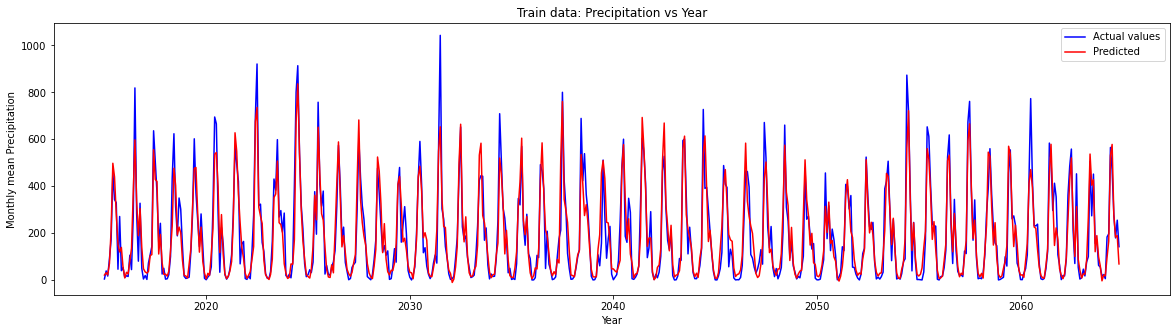

In [31]:
plt.figure(figsize=(20,5))
plt.plot(trainActual, color='blue', label='Actual values')
plt.plot(trainPredictdf, color='red', label='Predicted')
plt.title('Train data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation')
plt.legend(loc='best')
trainActual.head(47)

In [32]:
testDates = pd.date_range(start='2016-01', freq='MS', periods=test_rainfall_data.shape[0]-12-1)

In [33]:
testActual = pd.DataFrame({'Precipitation': testY[0]})
testActual.index = testDates

testPredictdf = pd.DataFrame({'Precipitation': testPredict[:,0]})
testPredictdf.index = testDates
testPredictdf.head(25)

,Precipitation
2016-01-01,-5.651624
2016-02-01,24.724318
2016-03-01,-42.185081
2016-04-01,85.360458
2016-05-01,237.198547
2016-06-01,589.795349
2016-07-01,531.253235
2016-08-01,466.612183
2016-09-01,8.720369
2016-10-01,187.335098


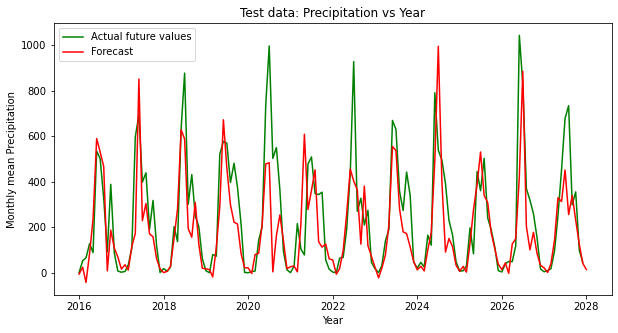

In [34]:
plt.figure(figsize=(10,5))
plt.plot(testActual, color='green', label='Actual future values')
plt.plot(testPredictdf, color='red', label='Forecast')
plt.title('Test data: Precipitation vs Year')
plt.xlabel('Year')
plt.ylabel('Monthly mean Precipitation')
plt.legend(loc='best')

In [47]:
def multi_step_forecasts(n_past, n_future):

    trainX_past = trainX[- n_past - 1:, :, :][:1]  # last observed input sequence
    trainY_past = trainY[- n_past - 1]             # last observed target value
    trainY_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        trainX_past = np.append(trainX_past[:, 1:, :],trainY_past.reshape(599), axis=1)

        # generate the next forecast
        trainY_past = model.predict(trainX_past)

        # save the forecast
        trainY_future.append(trainY_past.flatten()[0])

    # transform the forecasts back to the original scale
    trainY_future = scaler.inverse_transform(np.array(trainY_future).reshape(-1, 1)).flatten()

     # add the forecasts to the data frame
    df_past = data.rename(columns={'Close': 'Actual'}).copy()

    df_future = pd.DataFrame(
        index=pd.bdate_range(start=data.index[- n_past - 1] + pd.Timedelta(days=1), periods=n_past + n_future),
        columns=['Forecast'],
        data=y_future
    )

    return df_past.join(df_future, how='outer')

# forecast the next 30 days
df1 = multi_step_forecasts(n_past=0, n_future=30)
df1.plot()

# forecast the last 20 days and the next 30 days
df2 = multi_step_forecasts(n_past=20, n_future=30)
df2.plot()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 1 dimension(s)